# Find the Best Model

## Imports and Datasets

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates

from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [2]:
data_files = ['data/1_economic_indicators.csv', 'data/2_home_values_in_ct.csv', 'data/3_home_listings_in_ct.csv', 'data/4_homes_sold_in_ct.csv',
              'data/5_news_headlines_sentiment.csv', 'data/6_headlines_2018_2024.csv', 'data/7_sold_above_listing.csv', 'data/8_median_sale_price.csv',
              'data/9_hartford_ct_real_estate_metrics.csv', 'data/10_bridgeport_ct_real_estate_metrics.csv', 'data/11_new_haven_ct_real_estate_metrics.csv',
              'data/12_national_home_values.csv', 'data/version_1.csv', 'data/news_headlines_sentiment.csv']

In [3]:
dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in data_files]

In [4]:
econ_df          = dfs[0] # 1978 - today
hval_df          = dfs[1] # 2000 - this year, 5 counties (monthly)
hinv_df          = dfs[2] # 2018 - this year, 5 counties (monthly)
hsold_df         = dfs[3] # 2008 - this year, 3 counties; hartford, bridgeport, new_haven (monthly)
sentm_df1        = dfs[4] # 2000 - 2016/7/1
sentm_df2        = dfs[5] # 2018 - 2024
hsold_above_df   = dfs[6] # 2018 (monthly)
hmedian_price_df = dfs[7] # 2008 (monthly) Median price avoids outliers
hartford_df      = dfs[8]
bridgeport_df    = dfs[9]
new_haven_df     = dfs[10]
nation_value_df  = dfs[11]
original_df      = dfs[12]
news_df          = dfs[13]

In [5]:
# Version 1
baseline_df = original_df.iloc[:, :5].copy()
baseline_df = pd.concat([baseline_df, original_df.iloc[:, -6:].copy()], axis=1)

In [6]:
# Version 2
econ_df = econ_df.loc['2018':].resample('M').mean().copy()
global_events_df = sentm_df2
hartford_county_df = econ_df.join(global_events_df).join(hartford_df).ffill().copy()
bridgeport_county_df = econ_df.join(global_events_df).join(bridgeport_df).ffill().copy()
new_haven_county_df = econ_df.join(global_events_df).join(new_haven_df).ffill().copy()

df = new_haven_county_df.copy()
label_encoder = LabelEncoder()

df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df['next_month_value'] = df['county_avg_value'].shift(-1)
df['increase'] = (df['next_month_value'] > df['county_avg_value']).astype(int)

df = df.drop(columns=['next_month_value']).copy()
df = df.dropna()

new_haven_county_df = df

In [7]:
# Version 3
econ_df = dfs[0]
df1 = econ_df['2000':].resample('M').mean().copy()
df2 = hval_df 
df3 = sentm_df2[['negative', 'neutral', 'positive']].copy().resample('M').mean() 
df4 = nation_value_df
df5 = sentm_df1[['negative', 'neutral', 'positive']].copy().resample('M').mean()
df4 = df4.rename(columns={'United States': 'value_national'})

col_names = {'Hartford, CT': 'value_hartford', 'Bridgeport, CT': 'value_bridgeport', 'New Haven, CT': 'value_new_haven','Norwich, CT': 'value_norwich', 'Torrington, CT': 'value_torrington'}
df2.rename(columns=col_names, inplace=True)
df3 = df3.interpolate(axis=0)
df3['sentiment'] = df3[['negative', 'neutral', 'positive']].idxmax(axis=1)
df5 = df5.interpolate(axis=0)
df5['sentiment'] = df5[['negative', 'neutral', 'positive']].idxmax(axis=1)

sentiment_df = pd.concat([df5, df3], axis=0)
sentiment_df = sentiment_df.interpolate(axis=0)
econ_value_sentiment_df = df1.join(df2).join(df4).join(sentiment_df)

df = econ_value_sentiment_df
df['negative'] = df['negative'].interpolate(method='linear')
df['neutral'] = df['neutral'].interpolate(method='linear')
df['positive'] = df['positive'].interpolate(method='linear')
df['sentiment'] = df[['negative', 'neutral', 'positive']].idxmax(axis=1)
econ_value_sentiment_df = df.ffill()

df = econ_value_sentiment_df.copy()
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df['next_month_value'] = df['value_new_haven'].shift(-1)
df['increase'] = (df['next_month_value'] > df['value_new_haven']).astype(int)
df = df.drop(columns=['next_month_value']).copy()

df = df.dropna()
econ_value_sentiment_df = df

In [8]:
# Version 4
df6 = econ_df['2000':].resample('W').mean().copy()
df7 = hval_df.resample('W').mean().copy() 
df8 = sentm_df2[['negative', 'neutral', 'positive']].copy().resample('W').mean() 
df9 = nation_value_df.resample('W').mean().copy()
df7 = df7.ffill()
df8 = df8.ffill()
df9 = df9.ffill()

df8['sentiment'] = df8[['negative', 'neutral', 'positive']].idxmax(axis=1)
df9 = df9.rename(columns={'United States': 'value_national'})
econ_value_sentiment_df_2 = df6.join(df7).join(df9).join(df8).ffill().copy()
econ_value_sentiment_df_2 = econ_value_sentiment_df_2.bfill()
df = econ_value_sentiment_df_2

df['next_value_new_haven'] = df['value_new_haven'].shift(-1)
df['increase'] = (df['next_value_new_haven'] > df['value_new_haven']).astype(int)
econ_value_sentiment_df_2 = df.dropna()
df = econ_value_sentiment_df_2.copy()

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df['next_month_value'] = df['value_new_haven'].shift(-1)
df['increase'] = (df['next_month_value'] > df['value_new_haven']).astype(int)
df = df.drop(columns=['next_month_value', 'next_value_new_haven']).copy()

df = df.dropna()
econ_value_sentiment_df_2 = df

In [9]:
# Version 5
econ_df = dfs[0]
df6 = econ_df.resample('W').mean().copy()
df7 = dfs[10].resample('W').mean().copy() 
df8 = sentm_df1[['negative', 'neutral', 'positive']].copy().resample('W').mean() 
df9 = nation_value_df.resample('W').mean().copy()
df7 = df7.ffill()
df8 = df8.ffill()
df9 = df9.ffill()
df8['sentiment'] = df8[['negative', 'neutral', 'positive']].idxmax(axis=1)
df9 = df9.rename(columns={'United States': 'value_national'})

econ_value_sentiment_df_3 = df6.join(df7).join(df9).join(df8).ffill().copy()
econ_value_sentiment_df_3 = econ_value_sentiment_df_3.bfill()
df = econ_value_sentiment_df_3

df['next_value'] = df['county_avg_value'].shift(-1)
df['increase'] = (df['next_value'] > df['county_avg_value']).astype(int)

econ_value_sentiment_df_3 = df.dropna()
df = econ_value_sentiment_df_3.copy()

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df = df.drop(columns=['next_value']).copy()

econ_value_sentiment_df_3 = df

# Training and Testing
1. Update the df variable to point to the dataset you wish to use for training. This involves assigning the dataset to the df variable, ensuring it is ready for the subsequent steps in the modeling process.

2. When running the model a second time, you will find a block of code commented out in the script. This is intended for use in the second iteration. To activate this code, simply remove the comment symbols (#) at the beginning of each line of the relevant code block. Uncommenting this code will allow you to run the additional or alternative processes specified for this iteration.

3. Repeat step 2 until version 4 is complete.


| Version | Features                    | Notes                                                                          |
|---------|-----------------------------|--------------------------------------------------------------------------------|
| 1       | 722 x 14                    | 2008 - 2022 Weekly units, the baseline model.                                  |
| 2       | 75 x 17                     | 2018 - 2024 Target variable is increase for New Haven County.                  |
| 3       | 290 x 17                    | 2000 - 2024 Home values for each county.                                       |
| 4       | 1264 x 17                   | 2000 - 2024 Weekly units.                                                      |
| 5       | 2411 x 18                   | 2018 - 2024 Use dataset 2 for hyperparameter tuning.                           |

In [10]:
# DO NOT MUTATE
models_df = pd.DataFrame(columns=['model', 'version', 'training_time', 'training_acc', 'testing_acc', 'difference'])

In [77]:
df_1 = baseline_df.copy()               
df_2 = new_haven_county_df.copy()        
df_3 = econ_value_sentiment_df.copy()   
df_4 = econ_value_sentiment_df_2.copy() 
df_5 = econ_value_sentiment_df_3.copy() 

df = df_1
version = 1
#df = df_2
#version = 2
#df = df_3
#version = 3
#df = df_4
#version = 4

In [78]:
test_size_dict = { 1: 0.2, 2: 0.3, 3: 0.3, 4: 0.2 }
test_size = test_size_dict[version]
target = 'increase'

X = df.drop(columns=[target]).copy()
y = df[target]

if version > 1:
    oversampler = RandomOverSampler(sampling_strategy=1)
    X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

## Identify Best Model
The models listed below will be evaluated to identify the best performers. Subsequently, the top 5 models, based on their initial performance, will be fine-tuned using GridSearchCV to optimize their parameters. This approach ensures a comprehensive review of various algorithmic strategies to determine the most effective models for the dataset, taking into consideration accuracy and efficiency.

* Logistic Regression
* Decision Tree
* Random Forest
* Support Vector Machines (SVM)
* Naive Bayes
* K-Nearest Neighbors (KNN)
* Gradient Boosting Machines
* Adaptive Boosting

In [79]:
log_reg = LogisticRegression(max_iter=2000)

start_time = time.time()
log_reg.fit(X_train, y_train)
end_time=time.time()

In [80]:
model = 'Logistic Regression'
training_time = end_time - start_time
training_acc = log_reg.score(X_train, y_train)
testing_acc = log_reg.score(X_test, y_test)
difference = training_acc - testing_acc
lr_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [81]:
models_df = pd.concat([models_df, lr_df], ignore_index=True)

In [82]:
cols = X.columns
coeff = log_reg.coef_[0]
coeffs = dict(zip(cols, coeff))
sorted_coeffs = sorted(coeffs.items(), key=lambda x: x[1], reverse=True)
coeffs_df = pd.DataFrame(sorted_coeffs, columns=['Feature', 'Coefficient'])

In [83]:
y_pred = log_reg.predict(X_test)
log_reg_report = classification_report(y_test, y_pred, zero_division=0)

print(log_reg_report)

              precision    recall  f1-score   support

           0       0.69      0.41      0.51       212
           1       0.58      0.81      0.68       214

    accuracy                           0.61       426
   macro avg       0.63      0.61      0.60       426
weighted avg       0.63      0.61      0.60       426



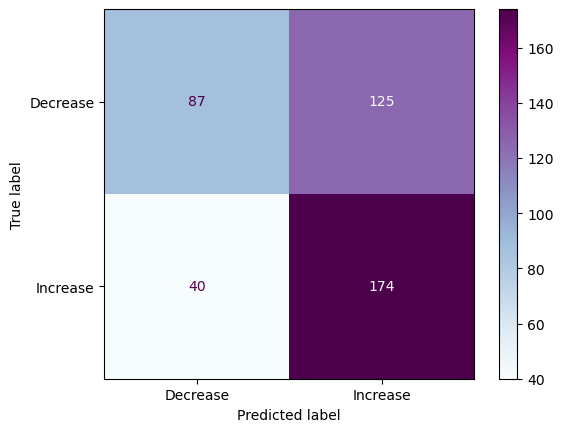

In [84]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Decrease', 'Increase'])

cmd.plot(cmap='BuPu')
plt.grid(False)
plt.show()

In [85]:
dt = DecisionTreeClassifier()

start_time = time.time()
dt.fit(X_train, y_train)
end_time=time.time()

In [86]:
model = 'Decision Tree'
training_time = end_time - start_time
training_acc = dt.score(X_train, y_train)
testing_acc = dt.score(X_test, y_test)
difference = training_acc - testing_acc
dt_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, dt_df], ignore_index=True)

In [87]:
svm = SVC()

start_time = time.time()
svm.fit(X_train, y_train)
end_time=time.time()

In [88]:
model = 'Support Vector Machines'
training_time = end_time - start_time
training_acc = svm.score(X_train, y_train)
testing_acc = svm.score(X_test, y_test)
difference = training_acc - testing_acc
svm_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, svm_df], ignore_index=True)

In [89]:
rf = RandomForestClassifier()
   
start_time = time.time()
rf.fit(X_train, y_train)
end_time=time.time()

In [90]:
model = 'Random Forest'
training_time = end_time - start_time

training_acc = rf.score(X_train, y_train)
testing_acc = rf.score(X_test, y_test)
difference = training_acc - testing_acc
rf_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, rf_df], ignore_index=True)

In [91]:
nb = GaussianNB()
   
start_time = time.time()
nb.fit(X_train, y_train)
end_time=time.time()

In [92]:
model = 'Naive Bayes'
training_time = end_time - start_time

training_acc = nb.score(X_train, y_train)
testing_acc = nb.score(X_test, y_test)
difference = training_acc - testing_acc
nb_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, nb_df], ignore_index=True)

In [93]:
gbm = GradientBoostingClassifier()

start_time = time.time()
gbm.fit(X_train, y_train)
end_time=time.time()

In [94]:
model = 'Gradient Boosting Machine'
training_time = end_time - start_time

training_acc = gbm.score(X_train, y_train)
testing_acc = gbm.score(X_test, y_test)
difference = training_acc - testing_acc
gbm_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, gbm_df], ignore_index=True)

In [95]:
ada = AdaBoostClassifier()

start_time = time.time()
ada.fit(X_train, y_train)
end_time=time.time()

In [96]:
model = 'Adaptive Boosting'
training_time = end_time - start_time

training_acc = ada.score(X_train, y_train)
testing_acc = ada.score(X_test, y_test)
difference = training_acc - testing_acc
ada_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, ada_df], ignore_index=True)

In [97]:
models_df = models_df.sort_values(by=['model', 'testing_acc'], ascending=[True, False])
models_df

,model,version,training_time,training_acc,testing_acc,difference
0,Adaptive Boosting,2,0.051106,1.000000,1.000000,0.000000
1,Adaptive Boosting,3,0.062728,0.992883,0.884298,0.108585
2,Adaptive Boosting,1,0.074191,0.861352,0.765517,0.095835
27,Adaptive Boosting,4,0.091255,0.678824,0.697183,-0.018360
3,Decision Tree,2,0.001544,1.000000,0.976190,0.023810
4,Decision Tree,3,0.002925,1.000000,0.909091,0.090909
22,Decision Tree,4,0.014534,1.000000,0.877934,0.122066
5,Decision Tree,1,0.004022,1.000000,0.786207,0.213793
6,Gradient Boosting Machine,2,0.073998,1.000000,1.000000,0.000000
7,Gradient Boosting Machine,3,0.117960,1.000000,0.933884,0.066116


In [98]:
no_v2 = models_df[models_df['version'] != 2]
no_v2.drop_duplicates(subset='model').nlargest(5, 'testing_acc')

,model,version,training_time,training_acc,testing_acc,difference
7,Gradient Boosting Machine,3,0.117960,1.000000,0.933884,0.066116
16,Random Forest,3,0.088946,1.000000,0.933884,0.066116
4,Decision Tree,3,0.002925,1.000000,0.909091,0.090909
1,Adaptive Boosting,3,0.062728,0.992883,0.884298,0.108585
13,Naive Bayes,3,0.006152,0.729537,0.801653,-0.072116


----

# Cross-validation and Grid Search Hyperparameters

In [99]:
# Hyperparameter Tuning
df = econ_value_sentiment_df_3.copy() 
version = 5
target = 'increase'

X = df.drop(columns=[target]).copy()
y = df[target]

oversampler = RandomOverSampler(sampling_strategy=1)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [100]:
lr = LogisticRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

param_grid = {
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    'max_iter' : [2000,3000,4000,5000]
}

lr_grid = GridSearchCV(lr, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)

start_time = time.time()
lr_grid.fit(X_train_scaled, y_train)
end_time=time.time()

best_estimator = lr_grid.best_estimator_
best_params = lr_grid.best_params_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [101]:
model = 'Logistic Regression Grid Search'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train_scaled, y_train)
testing_acc = best_estimator.score(X_test_scaled, y_test)
difference = training_acc - testing_acc

lr_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])
models_df = pd.concat([models_df, lr_df], ignore_index=True)

In [102]:
ada_boost = AdaBoostClassifier(estimator=best_estimator)

ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0]
}

ada_boost_grid = GridSearchCV(ada_boost, ada_param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)
start_time = time.time()
ada_boost_grid.fit(X_train_scaled, y_train)
end_time=time.time()

best_estimator = ada_boost_grid.best_estimator_
best_params = ada_boost_grid.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [103]:
model = 'ADA Boost Grid Search'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train_scaled, y_train)
testing_acc = best_estimator.score(X_test_scaled, y_test)
difference = training_acc - testing_acc

ada_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])
models_df = pd.concat([models_df, ada_df], ignore_index=True)

In [104]:
gb_classifier = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train_scaled, y_train)
best_params = gb_grid_search.best_params_
best_estimator = gb_grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [105]:
model = 'Gradient Boosting Grid Search'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train_scaled, y_train)
testing_acc = best_estimator.score(X_test_scaled, y_test)
difference = training_acc - testing_acc

gb_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])
models_df = pd.concat([models_df, gb_df], ignore_index=True)

In [106]:
rf_classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_grid_search = GridSearchCV(rf_classifier, param_grid, scoring='accuracy', cv=5)
rf_grid_search.fit(X_train_scaled, y_train)

best_rf_estimator = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_

In [107]:
model = 'Random Forest Grid Search'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train_scaled, y_train)
testing_acc = best_estimator.score(X_test_scaled, y_test)
difference = training_acc - testing_acc

rf_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])
models_df = pd.concat([models_df, rf_df], ignore_index=True)

In [108]:
dt = DecisionTreeClassifier()

param_grid = {
    'ccp_alpha': [0, 0.002, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['random', 'best']
}

dt_grid = GridSearchCV(dt, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)
start_time = time.time()
dt_grid.fit(X_train_scaled, y_train)
end_time=time.time()

best_estimator = dt_grid.best_estimator_
best_params = dt_grid.best_params_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [109]:
model = 'Decision Tree Grid Search'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train_scaled, y_train)
testing_acc = best_estimator.score(X_test_scaled, y_test)
difference = training_acc - testing_acc

dt_df = pd.DataFrame({'model': model, 'version': version, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])
models_df = pd.concat([models_df, dt_df], ignore_index=True)

# Interpretation of Models
The second version of the dataset featured the best attributes but was constrained by its size. This limitation led to models overfitting the small dataset. My initial hypothesis posited that supply and demand would significantly influence the fluctuations in home values.

The Logistic Regression model and ADA Boost, both fine-tuned with GridSearchCV, achieved an accuracy of over 95%. One notable advantage of the logistic regression model is its interpretability. The best parameters identified were: 

| Model               | Parameter     | Value  | Training Time | Training Acc | Testing Acc |
| ------------------- |---------------|--------|---------------| -------------|-------------|
| Logistic Regression | max_iter      | 2000   | 0.482853      | 0.939418     | 0.954109    |
|                     | penalty       | L2     |               |              |             |
|                     | solver        | lbfgs  |               |              |             |
| Adaptive Boosting   | learning_rate | 1.0    | 0.067921      | 0.936483     | 0.950907    |
|                     | n_estimators  | 150    |

The remaining models encountered issues with overfitting the training data. Particularly, the Random Forest model demonstrated high variance across all dataset versions, with its variance remaining unchanged regardless of modifications to the dataset. Datasets 1 and 4 contributed to a reduction in variance for the Gradient Boosting Machine, yet hyperparameter tuning failed to enhance testing accuracy. Additionally, the performance of the Decision Tree model did not improve with hyperparameter tuning.

In [110]:
no_v2 = models_df[models_df['version'] != 2]
no_v2.sort_values(by=['testing_acc'], ascending=[False]).head(5)

,model,version,training_time,training_acc,testing_acc,difference
28,Logistic Regression Grid Search,5,1.544747,0.939685,0.953042,-0.013357
29,ADA Boost Grid Search,5,3.605847,0.936749,0.950907,-0.014158
9,Gradient Boosting Machine,3,0.117960,1.000000,0.933884,0.066116
21,Random Forest,3,0.088946,1.000000,0.933884,0.066116
5,Decision Tree,3,0.002925,1.000000,0.909091,0.090909


## Identification and Interpretation of Evaluation Metric
The logistic regression model performed exceptionally well in predicting decreases in value. The high precision score for predicting decreases may be attributed to the overall downtrend observed in the market for the year 2018. This trend likely contributed to the model's difficulty in accurately predicting increases in value, as indicated by the error in recall for increasing prices.

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       477
           1       0.91      1.00      0.95       460

    accuracy                           0.95       937
   macro avg       0.96      0.95      0.95       937
weighted avg       0.96      0.95      0.95       937



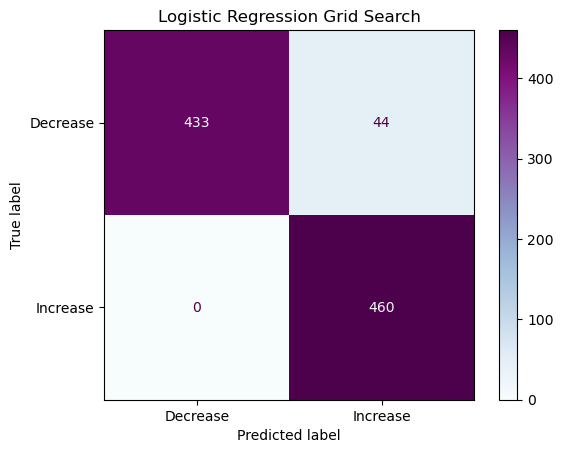

In [112]:
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

log_reg_report = classification_report(y_test, y_pred, zero_division=0)
print(log_reg_report)

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Decrease', 'Increase'])

cmd.plot(cmap='BuPu')
plt.grid(False)
plt.title('Logistic Regression Grid Search')
plt.show()

## Rationale for use of Evaluation Metric
Optimizing for a high precision score is particularly crucial for people who are risk-averse. A model that has a high precision score is most effective for accurately determining decreases in home values. This precision ensures that when the model predicts a decrease, there is a high likelihood that this prediction is correct, minimizing the risk of making decisions based on false predictions of market downturns.

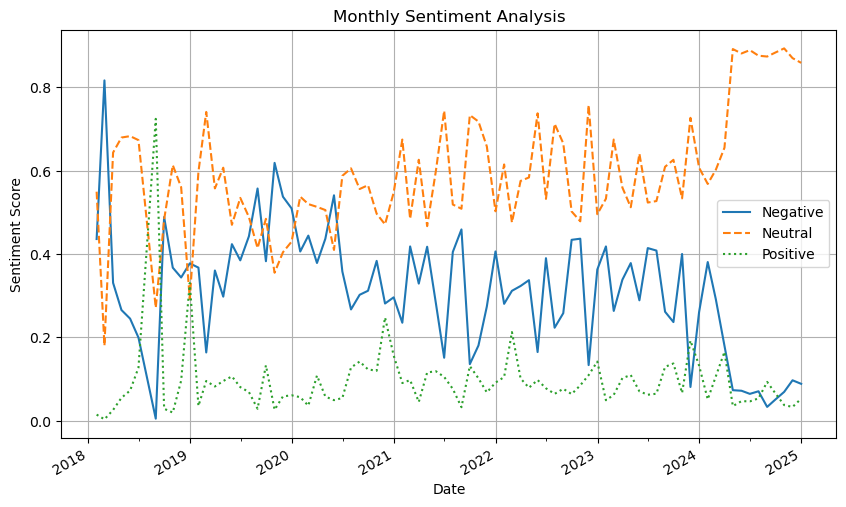

In [113]:
monthly_df = sentm_df2
plt.figure(figsize=(10, 6))

sns.lineplot(data=monthly_df['negative'], label='Negative')
sns.lineplot(data=monthly_df['neutral'], label='Neutral', linestyle='--')
sns.lineplot(data=monthly_df['positive'], label='Positive', linestyle=':')

plt.title('Monthly Sentiment Analysis')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(7))
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid(True)
plt.show()

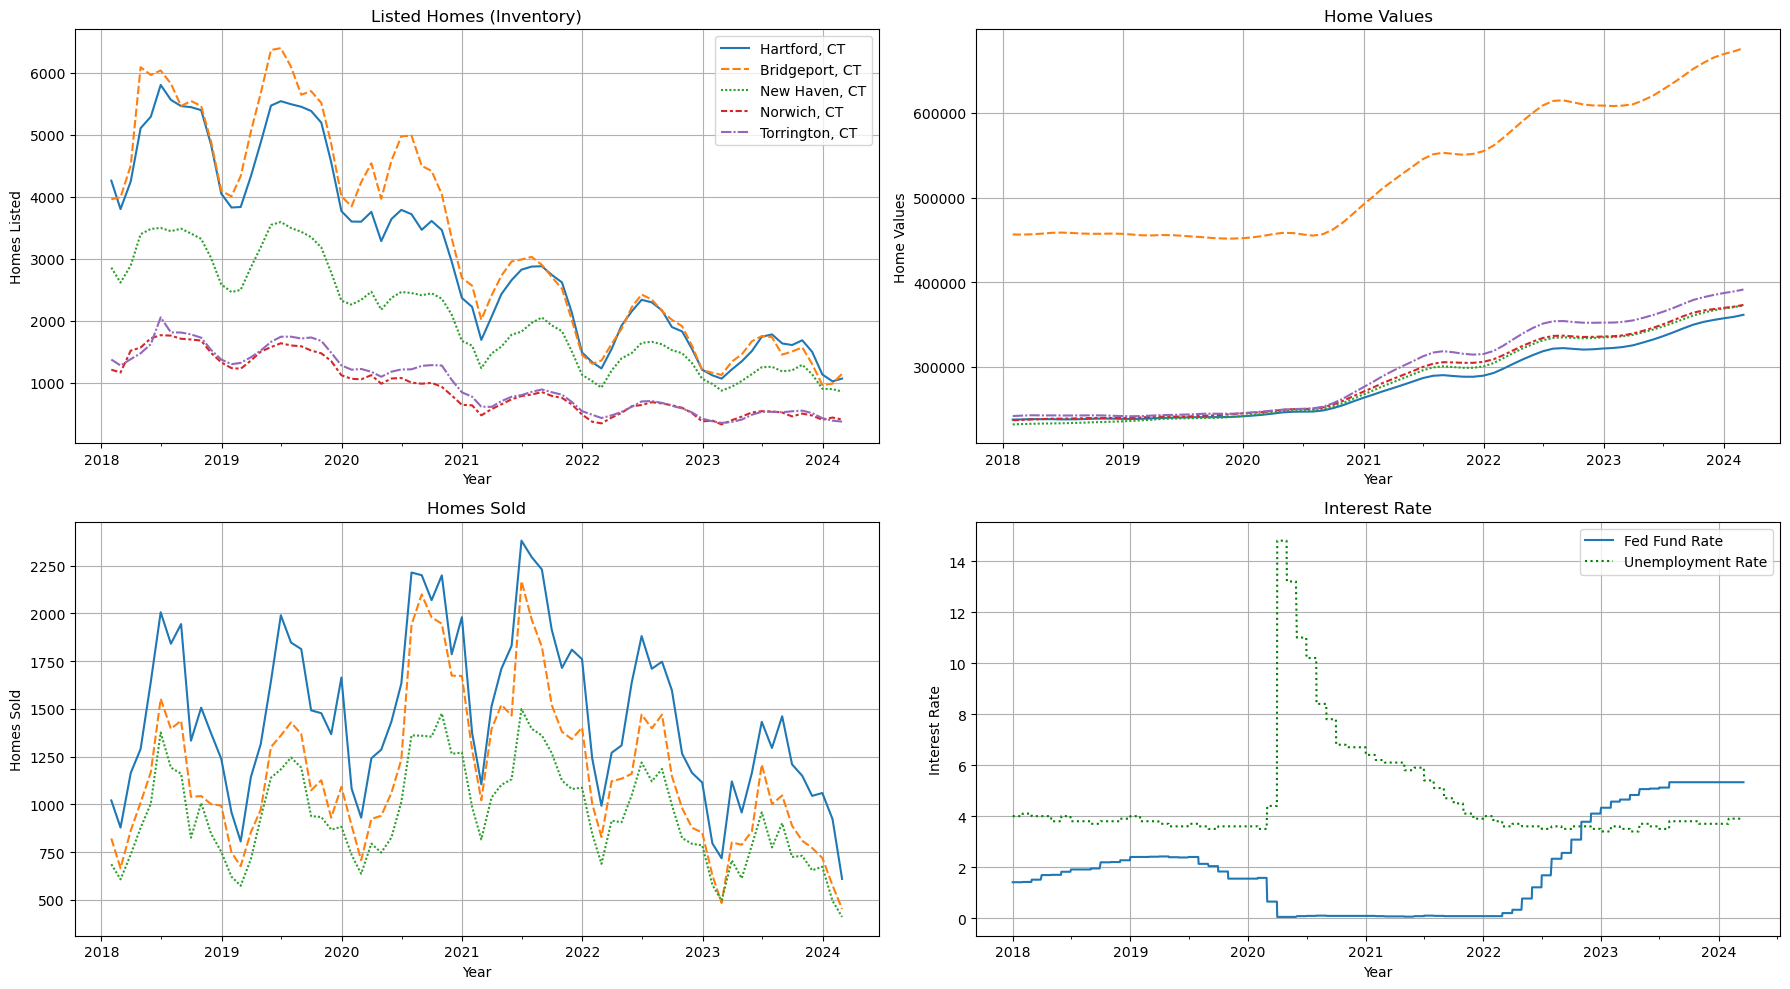

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
for ax in axes.flatten():
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(7)) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
       
sns.lineplot(data=hinv_df['2018':], ax=axes[0, 0])
axes[0, 0].set_title('Listed Homes (Inventory)')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Homes Listed')

sns.lineplot(data=hval_df['2018':], ax=axes[0, 1])
axes[0, 1].set_title('Home Values')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Home Values')
axes[0, 1].legend().remove()

sns.lineplot(data=hsold_df['2018':], ax=axes[1, 0])
axes[1, 0].set_title('Homes Sold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Homes Sold')
axes[1, 0].legend().remove()

sns.lineplot(data=econ_df['2018':]['interest'], label='Fed Fund Rate')
sns.lineplot(data=econ_df['2018':]['unemp_rate'], color="green", label='Unemployment Rate', linestyle='dotted')
axes[1, 1].set_title('Interest Rate')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Interest Rate')

axes[0, 0].grid(True)
axes[0, 1].grid(True)
axes[1, 0].grid(True)
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

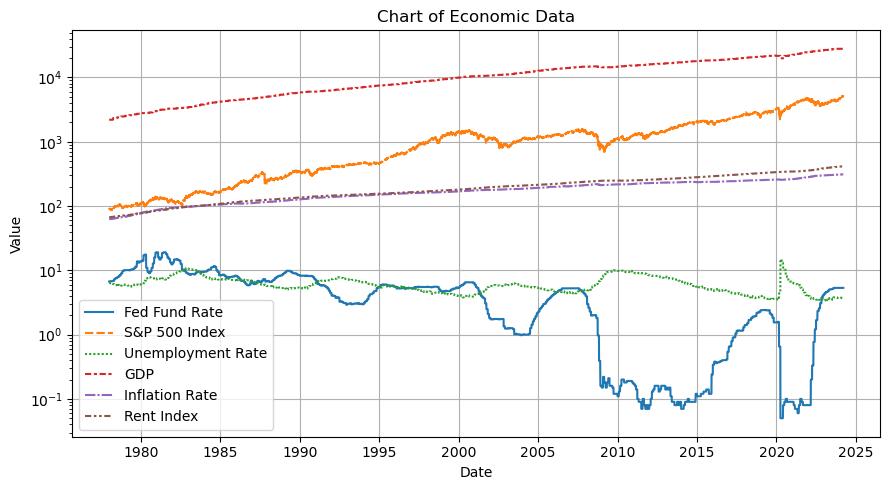

In [115]:
df = dfs[0]
plt.figure(figsize=(9, 5))
df.columns = ['Fed Fund Rate','S&P 500 Index', 'Unemployment Rate', 'GDP', 'Inflation Rate', 'Rent Index']
sns.lineplot(data=df)

plt.title('Chart of Economic Data')
plt.xlabel('Date')
plt.ylabel('Value')

plt.yscale('log')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5)) 
plt.grid(True)
plt.tight_layout()

plt.show()

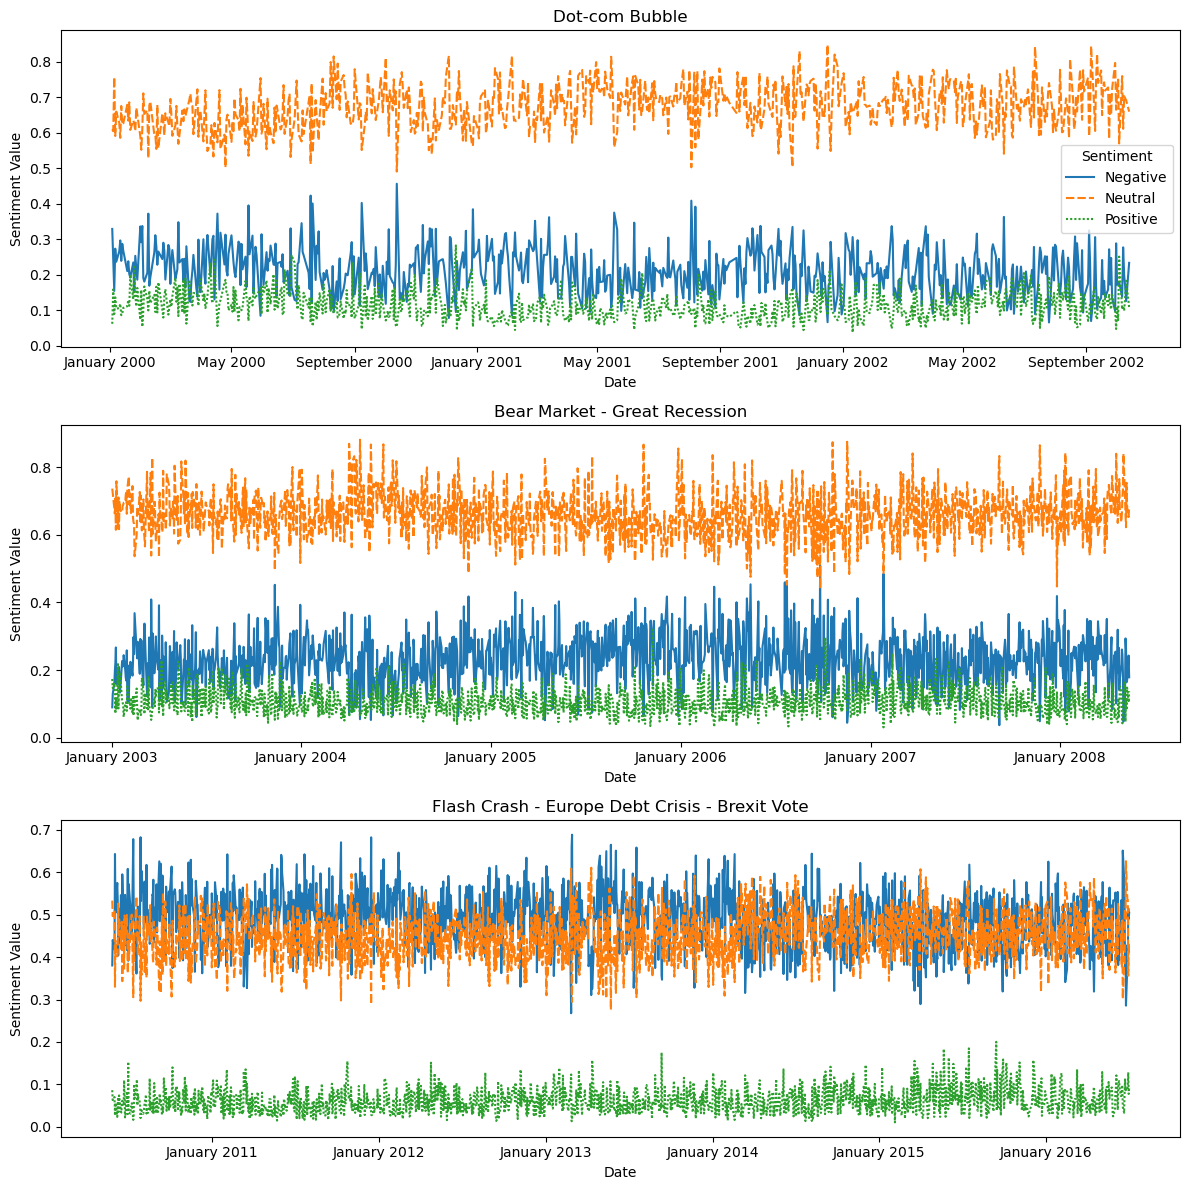

In [116]:
sentiment_distribution = news_df[['negative', 'neutral', 'positive']].copy()
sentiment_distribution.columns = sentiment_distribution.columns.str.capitalize()
                
subplots_data = [
    (sentiment_distribution[:'2002-10'], 'Dot-com Bubble'),
    (sentiment_distribution['2003':'2009'], 'Bear Market - Great Recession'),
    (sentiment_distribution['2009':], 'Flash Crash - Europe Debt Crisis - Brexit Vote')
]

fig, axes = plt.subplots(len(subplots_data), 1, figsize=(12, 4 * len(subplots_data)))

for i, (df, title) in enumerate(subplots_data):
    sns.lineplot(data=df, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sentiment Value')
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
    axes[i].legend().remove()

axes[0].legend(title='Sentiment')
plt.tight_layout()
plt.show()

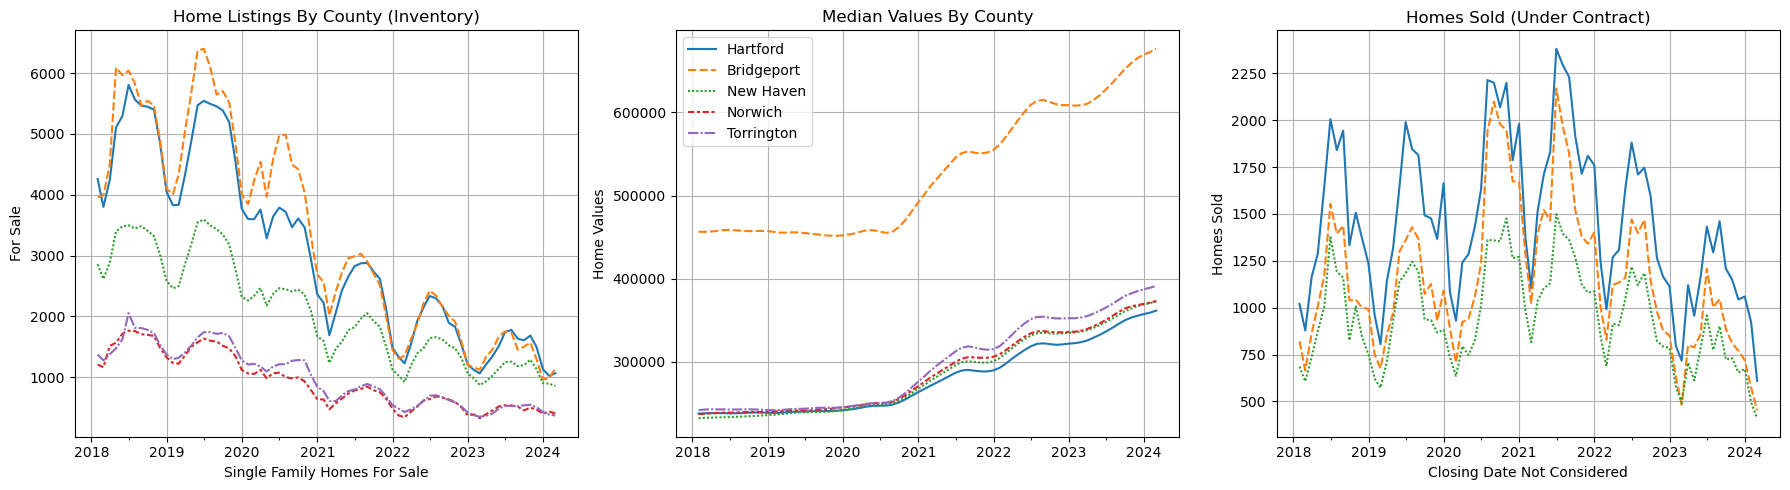

In [118]:
col_names = {
    'value_hartford': 'Hartford',
    'value_bridgeport': 'Bridgeport',
    'value_new_haven': 'New Haven',
    'value_norwich': 'Norwich',
    'value_torrington': 'Torrington',
}
hval_df.rename(columns=col_names, inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)  
    ax.tick_params(axis='x', rotation=0)  
    
sns.lineplot(data=hinv_df['2018':], ax=axes[0])
axes[0].set_title('Home Listings By County (Inventory)')
axes[0].set_xlabel('Single Family Homes For Sale')
axes[0].set_ylabel('For Sale')
axes[0].legend().remove()  

sns.lineplot(data=hval_df['2018':], ax=axes[1])
axes[1].set_title('Median Values By County')
axes[1].set_ylabel('Home Values')

sns.lineplot(data=hsold_df['2018':], ax=axes[2])
axes[2].set_title('Homes Sold (Under Contract)')
axes[2].set_xlabel('Closing Date Not Considered')
axes[2].set_ylabel('Homes Sold')
axes[2].legend().remove()  

plt.tight_layout()
plt.show()

# Summary
After organizing and examining the data, it became evident when the best times to buy a house are. The real estate market moves in predictable cycles with clear trends. The number of homes listed for sale and the number sold each year follow a regular pattern: activity picks up at the beginning of the year, reaches its highest point around the middle of the year, and then slows down as the year ends. For those looking to have a wide range of options, the middle of the year is when the market is most active. However, for those seeking a good deal before prices rise, the beginning of the year is the optimal time to buy, especially in markets where prices are generally on the rise. Although home listing data was available for only the last six years, it was observed that as the number of homes sold decreased, so did the prices.

The economic indicators for 2018 were somewhat unusual, due to the Federal Reserve keeping interest rates exceptionally low for about eight years. Just as they began to raise rates, the COVID-19 pandemic occurred, further distorting the data. The unemployment rate soared to its highest in 40 years, topping 14%.

As for market sentiment — the overall feel of the market based on news headlines and global events — it did not significantly aid the analysis. The data used in the TweetEval model indicated that most news coverage focused on negative or neutral stories, with a significant emphasis on conflicts and wars. For sentiment analysis to provide meaningful insights, a more balanced mix of positive news is required. However, this is challenging, as positive news and events tend to be reported less frequently.